In [1]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

from vortexasdk import CargoTimeSeries, Products

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

# Crude Floating Storage and its relation to Prices

The oil markets are in turmoil. Demand for crude oil has collapsed due to the COVID-19 pandemic, and supply has surged due to the Russia-Saudi Arabia price war, causing an unprecedented oil glut that is rapidly filling land-based storage. [Vortexa data](https://analytics.vortexa.com/?activeTemplateId=b6c73502e93045b90c7fd05620f24b5d936695bb&page=Storage&tabId=e151735d-c29a-49e8-bceb-a7c35ef0d047&unit=t) shows that global crude oil floating storage has been steadily increasing since mid-March, suggesting that storage demand has started spilling over to seaborne storage.

In this Notebook we analyse Vortexa's crude oil floating storage data (retrieved using our [Python SDK](https://github.com/VorTECHsa/python-sdk)) and its relationship to crude oil prices. Floating storage is directly determined by oil prices and market dynamics; however, it is not known whether floating storage may be predictive of oil prices in the future. In other words, can floating storage be used as a trading signal for crude oil? Here we apply Granger causality analysis on floating storage and price data, and for the first time demonstrate that floating storage may have significant predictive value for spot crude oil prices 2-3 months into the future.

# Fetching and Visualising the Data

## Vortexa global crude oil floating storage data

For this analysis, we will look at the 4-year period ending in 31 January 2020, before the COVID-19 pandemic had a significant impact on floating storage.

In [2]:
# Defining date range for historical analysis
# NB: Vortexa data is currently available from 2016-01-01 with a maximum date range of 4 years per query 
START_DATE = datetime(2016, 1, 31)
END_DATE = datetime(2020, 1, 31)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)

# Define floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

We use the [CargoTimeSeries](https://vortechsa.github.io/python-sdk/endpoints/cargo_timeseries/) endpoint to download floating storage data from Vortexa. The function below makes an API query to retrieve the time series of global crude floating storage. The only filters set in this query are the required start and end time, the activity (set to `storing_state` for floating storage), and the product (set to Crude/Condensates; similar results are obtained if only Crude is selected, as Condensate floating storage volumes are low). The frequency of the time series is set to daily (the most granular available), and unit to metric tonnes (`t`; for barrels use `b`). Importantly, `disable_geographic_exclusion_rules` is set to `True` so that intra-country movements are included in the aggregation. Unless this parameter is set the default behaviour is to ignore cargo movements that load and discharge in the same country. Finally, we do not set `filter_storage_locations` so that the query will return the total amount of crude stored globally. 

In [3]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)
    
    return df_fs

The function above makes the API query and returns a Pandas DataFrame with the time series data. Vessels in floating storage are considered to be in cargo movements, and CargoTimeSeries() will return a count of cargo movements satisfying the filters and their total volume. When the function is run, the SDK prints some log messages confirming the parameters used in the query. 

In [4]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

2020-04-17 05:36:37,978 vortexasdk.operations — INFO — Searching Products with params: {'term': ['crude'], 'ids': [], 'product_parent': [], 'allowTopLevelProducts': True}
2020-04-17 05:36:37,981 vortexasdk.client — INFO — Creating new VortexaClient
2020-04-17 05:36:38,262 vortexasdk.client — INFO — 18 Results to retreive. Sending 1 post requests in parallel using 6 threads.
2020-04-17 05:36:38,667 vortexasdk.operations — INFO — Searching CargoTimeSeries with params: {'filter_activity': 'storing_state', 'filter_time_min': '2016-01-31T00:00:00.000Z', 'filter_time_max': '2020-01-31T00:00:00.000Z', 'timeseries_activity_time_span_min': None, 'timeseries_activity_time_span_max': None, 'filter_charterers': [], 'filter_owners': [], 'filter_products': ['54af755a090118dcf9b0724c9a4e9f14745c26165385ffa7f1445bc768f06f11'], 'filter_vessels': [], 'filter_destinations': [], 'filter_origins': [], 'filter_storage_locations': [], 'filter_ship_to_ship_locations': [], 'filter_waypoints': [], 'disable_geog

,date,t,number_of_cargo_movements
0,2016-01-31,7436278,108
1,2016-02-01,7841026,107
2,2016-02-02,7555497,114
3,2016-02-03,8065912,120
4,2016-02-04,8329186,118
...,...,...,...
1457,2020-01-27,7919126,118
1458,2020-01-28,8155308,121
1459,2020-01-29,8501078,124
1460,2020-01-30,8081172,117


The returned dataframe contains the dates spanning the requested range, the quantity in the requested unit (tonnes), and the number of cargo movements included in the aggregation. We now create a Pandas Series to hold the floating storage quantity in kilotonnes (kt) and plot this data: 

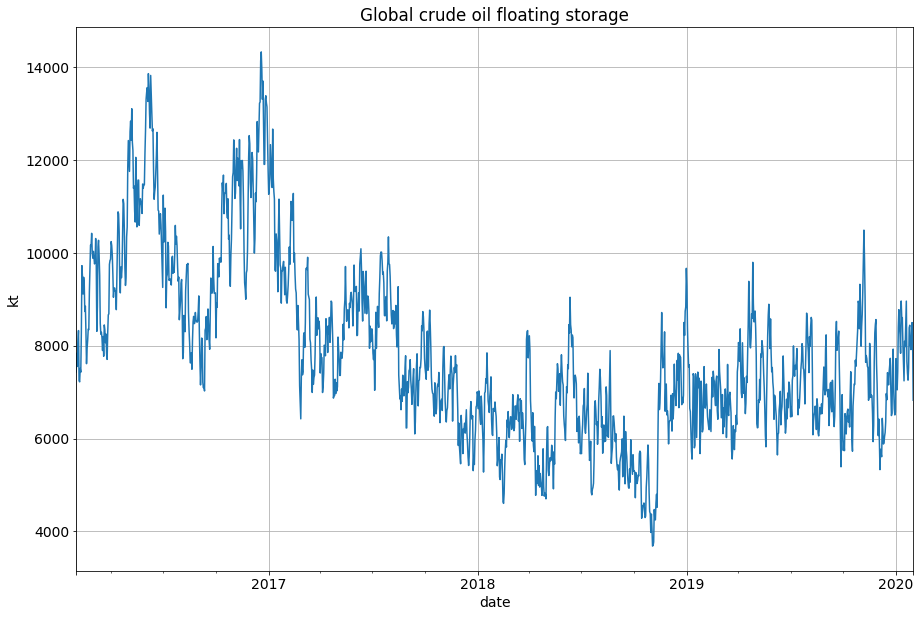

In [5]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global crude oil floating storage', grid=True)
plt.xlabel('date')
plt.ylabel('k' + UNIT);

The broader trend suggests that global floating storage peaked in 2016 and then decreased until the end of 2018, after which it slowly increased until the January 2020. We will now see how the crude oil prices were behaving during this period.

## EIA crude oil prices 

The US Energy Information Administration (EIA) reports daily [spot prices](https://www.investopedia.com/terms/s/spotprice.asp) of crude oil and other products on their [website](https://www.eia.gov/dnav/pet/pet_pri_spt_s1_d.htm). This data is publicly available and we download the Excel file directly into a Pandas DataFrame below. (NB: although the series has daily resolution, the Excel file is updated on a weekly basis. For details see the information in the [Regular Weekly Releases](https://www.eia.gov/petroleum/data.php#summary) box.) `ffill` is used to fill gaps in the price data, so we can compare the latest price against floating storage. 

In [6]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
spot_prices

,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2016-01-31,33.66,33.14
2016-02-01,31.62,32.45
2016-02-02,29.90,30.98
2016-02-03,32.29,32.38
2016-02-04,31.63,32.76
...,...,...
2020-01-27,53.09,58.54
2020-01-28,53.33,59.37
2020-01-29,53.29,59.46
2020-01-30,52.19,57.72


We open the sheet containing the crude oil spot prices (sheet `Data 1`) in the DataFrame and see that it contains two series: `Cushing, OK WTI Spot Price` and `Europe Brent Spot Price`. WTI (West Texas Intermediate) is the name of a crude oil grade produced in the US, and Brent is a crude grade produced in the North Sea. Both prices are used as international benchmark in oil transactions. This data is plotted below.

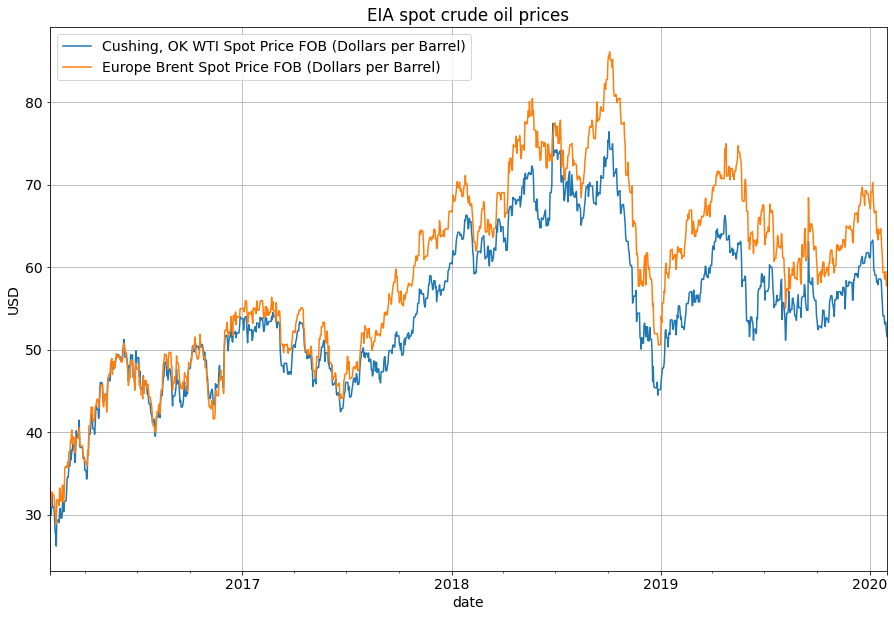

In [7]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

We proceed the analysis with `Cushing, OK WTI Spot Price`, which is kept as a Pandas Series below. We choose WTI because EIA provides both spot and future prices for WTI, but not for Brent.

In [8]:
spot_prices = spot_prices.iloc[:, 0]

Next we retrieve [future prices](https://www.investopedia.com/terms/f/futures.asp) also from [EIA](https://www.eia.gov/dnav/pet/pet_pri_fut_s1_d.htm). We download the Excel file with the historical price data of [NYMEX WTI Future contracts](https://www.cmegroup.com/trading/why-futures/welcome-to-nymex-wti-light-sweet-crude-oil-futures.html) into a DataFrame.

In [9]:
future_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
future_prices = future_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
future_prices

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2016-01-31,33.62,35.28,36.78,38.00
2016-02-01,31.62,33.36,34.93,36.23
2016-02-02,29.88,31.61,33.24,34.63
2016-02-03,32.28,33.86,35.39,36.67
2016-02-04,31.72,33.38,34.95,36.30
...,...,...,...,...
2020-01-27,53.14,53.18,53.13,52.97
2020-01-28,53.48,53.52,53.48,53.33
2020-01-29,53.33,53.41,53.42,53.31
2020-01-30,52.14,52.23,52.27,52.23


The `Data 1` sheet in the Excel file contains the prices of four different crude oil future contracts (Contract 1-4). "Contract 1" sets the physical delivery of crude oil in the month following the expiry date of the contract, "Contract 2" sets the delivery 2 months ahead, and so on until "Contract 4" (for details please refer [here](https://www.eia.gov/dnav/pet/TblDefs/pet_pri_fut_tbldef2.asp)). A plot of the four future contract prices is shown below.   

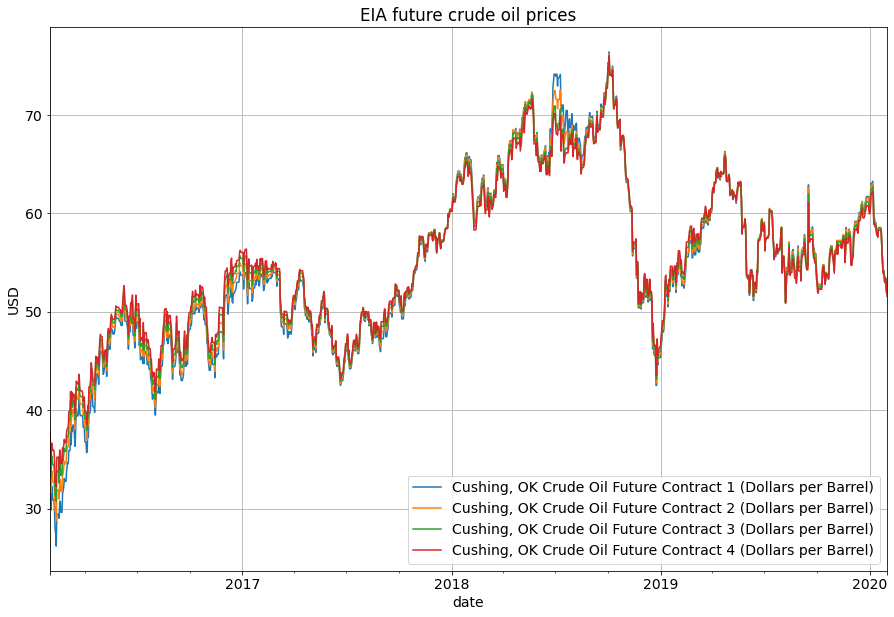

In [10]:
future_prices.plot(title='EIA future crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

Next we calculate the difference between the future prices and the spot price, also known as [calendar spread](https://www.investopedia.com/terms/c/calendarspread.asp).

In [11]:
calendar_spread = future_prices - pd.concat([spot_prices] * 4, axis=1).values
calendar_spread

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2016-01-31,-0.04,1.62,3.12,4.34
2016-02-01,0.00,1.74,3.31,4.61
2016-02-02,-0.02,1.71,3.34,4.73
2016-02-03,-0.01,1.57,3.10,4.38
2016-02-04,0.09,1.75,3.32,4.67
...,...,...,...,...
2020-01-27,0.05,0.09,0.04,-0.12
2020-01-28,0.15,0.19,0.15,0.00
2020-01-29,0.04,0.12,0.13,0.02
2020-01-30,-0.05,0.04,0.08,0.04


Plotting the calendar spreads makes it easy to visualise the periods in which the crude oil market was in [contango](https://www.investopedia.com/terms/c/contango.asp) (spread > 0) and in [backwardation](https://www.investopedia.com/terms/b/backwardation.asp) (spread < 0).

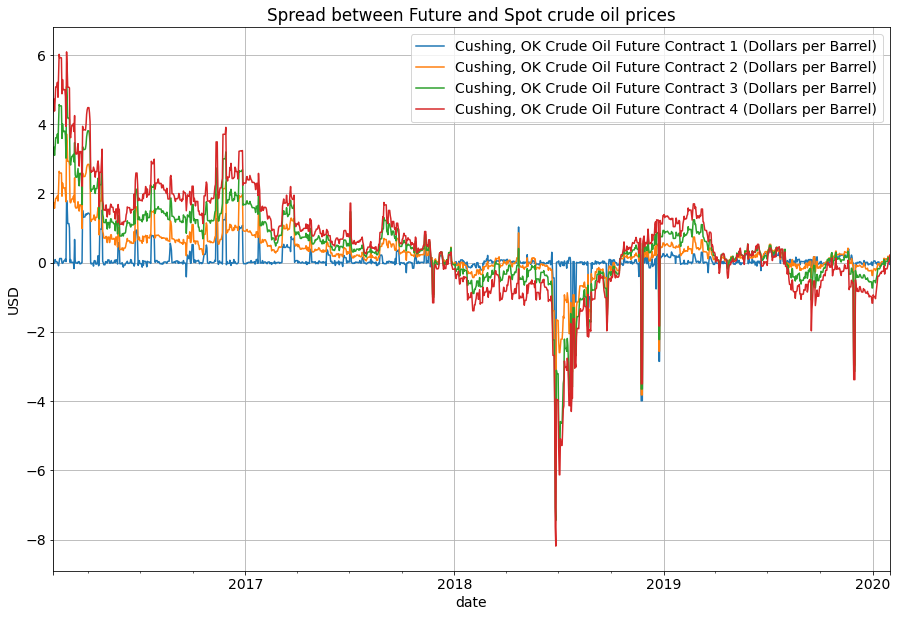

In [12]:
calendar_spread.plot(title='Spread between Future and Spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

We will continue the analysis with "Cushing, OK Crude Oil Future Contract 4" future prices and the corresponding calendar spread, both as Pandas Series.

In [13]:
future_prices = future_prices.iloc[:, 3]
calendar_spread = calendar_spread.iloc[:, 3]

# Cross-correlation analysis

In [14]:
# Maximum lag in days used for cross-correlation and Granger causality analysis
MAXLAG = 100

We start investigating the relationship between floating storage and prices by doing a simple [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation) analysis. For this, we use the [pandas.Series.corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.corr.html) function to compute the Pearson correlation coefficient between two time series as we slide one of them in time using the [shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.shift.html) function.

In [15]:
def crosscorr(series_x, series_y, lags):
    return pd.Series([series_y.corr(series_x.shift(lag)) for lag in lags], index=lags)

To illustrate how this function works, let's look at the first few lags when we cross-correlated `calendar_spread` and `floating_storage`:

In [16]:
crosscorr(calendar_spread, floating_storage, lags=[0, 1])

0    0.572660
1    0.576399
dtype: float64

All values are [Pearson correlation coefficients](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the two input variables. The index values correspond to the number of days the first variable is shifted "down" relative to the second one, so past values of the first variable are correlated against the present values of the second variable. In the above example, at index `1` "today's" floating storage is correlated with "yesterday's" calendar spread, or equivalently the calendar spread is correlated against floating storage 1 day in the future.

To help visualise the cross-correlation between the different variables, we define the following function: 

In [17]:
def plot_crosscorr(series_x, series_y, maxlag, label_x, label_y):
    lags = np.arange(0, maxlag+1)

    plt.subplot('211')
    xcorr_x_y = crosscorr(series_x, series_y, lags)
    xcorr_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.ylabel('correlation coeff.')

    plt.subplot('210')
    xcorr_y_x = crosscorr(series_y, series_x, lags)
    xcorr_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.xlabel('lag [days]')
    plt.ylabel('correlation coeff.')

`plot_crosscorr` splits the cross-correlation results in two: the top plot has the correlation values between `series_x` and future values of `series_y`, and the bottom plot the correlation between `series_y` and future values of `series_x`. Plotting the cross-correlation between calendar spread and floating storage we obtain:

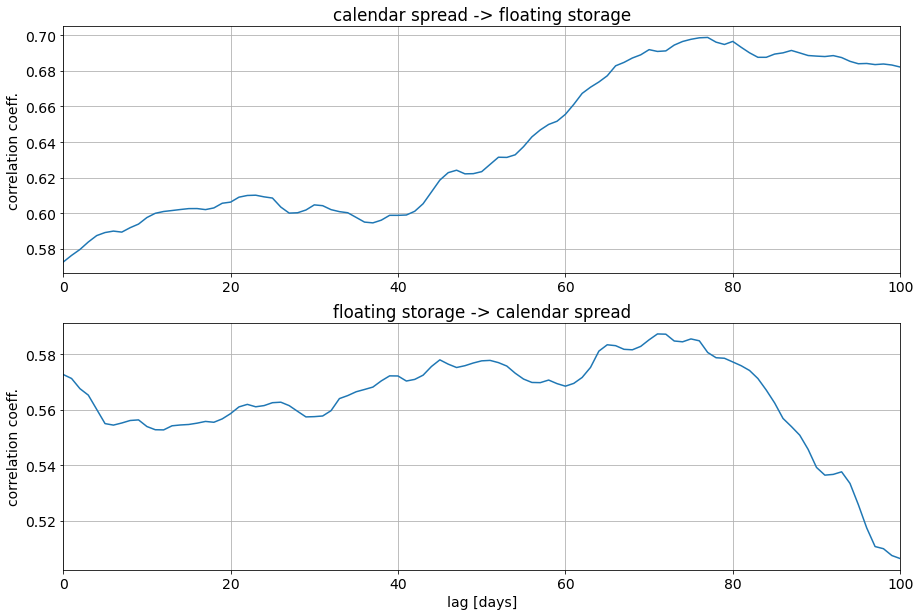

In [18]:
plot_crosscorr(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

Calendar spread and floating storage are positively correlated over the entire range of lag values examined. The largest value corresponds to the correlation between calendar spread and floating storage around 80 days in the future (top plot).

Next we cross-correlate spot prices and floating storage:

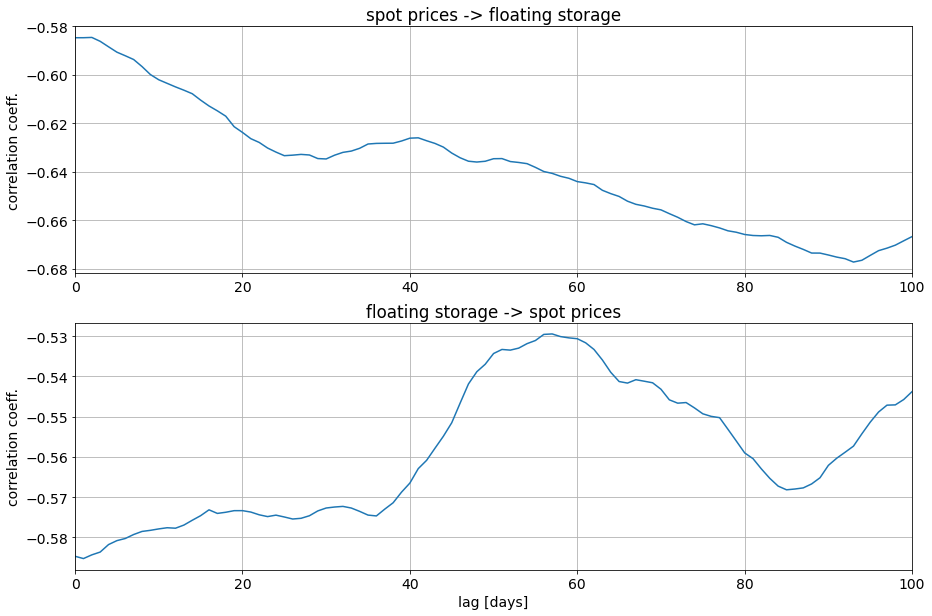

In [19]:
plot_crosscorr(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

Spot prices are negatively correlated with floating storage over the entire range of lag values. The largest negative amplitude was found when spot prices were correlated with floating storage ~90 days in the future.

Though useful to detect potential links between variables, cross-correlation is notoriously difficult to interpret. One of the main shortcomings of cross-correlation analysis is that it doesn't disentangle the temporal correlations within each time series (i.e., their [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)) and between time series. If `x` and `y` are correlated with zero lag, and future values of `y` are correlated with the present value of `y`, then chances are `x` is also correlated with future values of `y` even if it does not have any direct causal link with future `y`.

We use the `crosscorr` function to calculate and plot the autocorrelation of each time series (alternatively one can use [pd.Series.autocorr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.autocorr.html) iteratively).

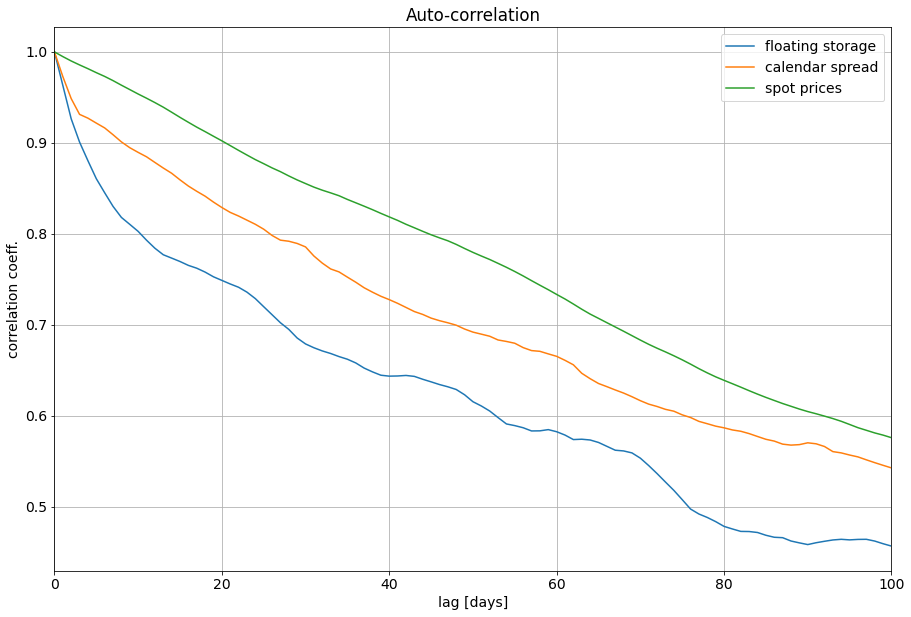

In [20]:
lags = np.arange(0, MAXLAG+1)

crosscorr(floating_storage, floating_storage, lags).plot()
crosscorr(calendar_spread, calendar_spread, lags).plot()
crosscorr(spot_prices, spot_prices, lags).plot()
plt.grid()
plt.title('Auto-correlation')
plt.legend(['floating storage', 'calendar spread', 'spot prices'])
plt.xlabel('lag [days]')
plt.ylabel('correlation coeff.');

As shown above, both spot prices and calendar spread have strong positive autocorrelations even after after 100 days (by definition, autocorrelation at lag 0 is always 1). This follows our intuition that price reversals don't have very frequently; if prices are up, they tend to stay up within this timeframe. We need a different tool to disentangle these correlations and identify significant links between floating storage and the price signals.

# Granger causality analysis

[Granger causality](http://www.scholarpedia.org/article/Granger_causality) is a statistical tool developed specifically to address the "autocorrelation" problem such as the one found above. Granger causality tests whether or not knowledge of `x` helps predict future values of `y` beyond what can be predicted by knowing past values of `y` (thereby controlling for `y`'s autocorrelation). It is commonly used in econometrics and neuroscience to identify potential causal links between multiple time series.

We use the [grangercausalitytests](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html) implementation provided in the `statsmodels` package. To check whether `calendar_spread` Granger-causes `floating_storage` with a lag of 1 or 2 days, we run:

In [21]:
gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.7489 , p=0.0000  , df_denom=1458, df_num=1
ssr based chi2 test:   chi2=18.7875 , p=0.0000  , df=1
likelihood ratio test: chi2=18.6677 , p=0.0000  , df=1
parameter F test:         F=18.7489 , p=0.0000  , df_denom=1458, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.7210  , p=0.0001  , df_denom=1455, df_num=2
ssr based chi2 test:   chi2=19.5088 , p=0.0001  , df=2
likelihood ratio test: chi2=19.3796 , p=0.0001  , df=2
parameter F test:         F=9.7210  , p=0.0001  , df_denom=1455, df_num=2


`grangercausalitytests` runs four different tests (`ssr based F test`, `ssr based chi2 test`, `likelihood ratio test`, `parameter F test`), all of which return similar results. `ssr based F test` and `parameter F test` are based on [F distribution](https://en.wikipedia.org/wiki/F-distribution), and `ssr based chi2 test` and `likelihood ratio test` are based on the [Chi-squared distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution).
For each test, it returns the test statistic, the p-value, and the degrees of freedom. The p-values returned above are all significant (i.e., lower than the conventional threshold of 0.05), suggesting that the second column (`calendar_spread`) Granger-causes the first column (`floating_storage`) at both 1- and 2-day lags.

The following function plots the Granger causality p-values obtained at each lag and for both directions (`x -> y` and `y -> x`). It also plots the confidence level as a visual aid for the easy identification of significant results.

In [22]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot('211')
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot('210')
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')

We now test for Granger causality between calendar spread and floating storage:

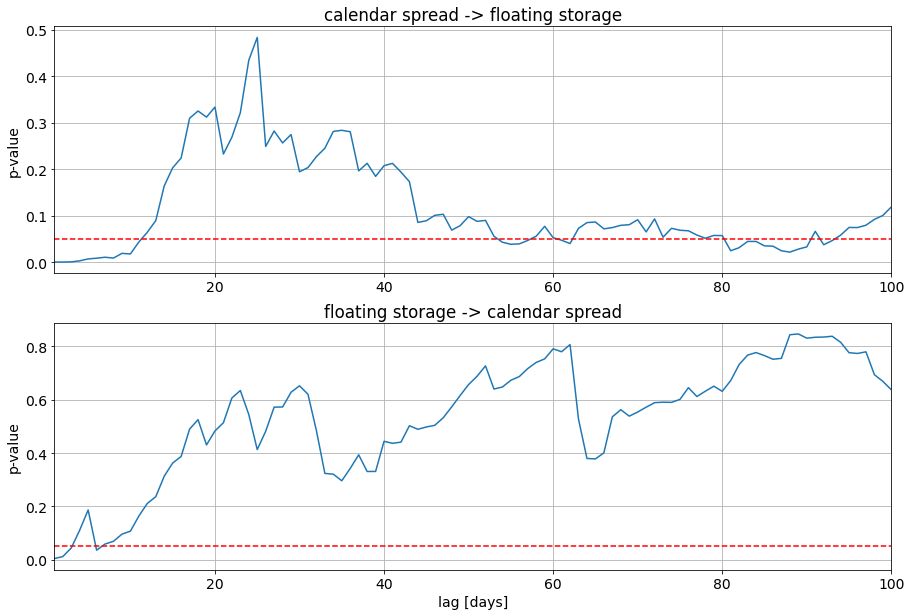

In [23]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

The blue lines indicate the p-values of the Granger causality tests, and to identify the significant results we need to look where the p-values dip below the threshold of significance (dashed red lines, set at the conventional threshold of 0.05).

Significant results were found in the top plot, suggesting that calendar spread Granger-causes floating storage both in the short term (1-10 days) and in the long-term (around ~60 days, and 80-90 days). This result was expected, as contango structure in the oil markets creates opportunities to profit by storing crude oil on tankers until prices move higher. The lags might reflect the time it takes to charter a vessel and pick up the cargo. On the other hand, the bottom plot shows no consistent evidence in the opposite direction (i.e. floating storage Granger-causing calendar spread).

Next we apply the Granger causality test between spot prices and floating storage:

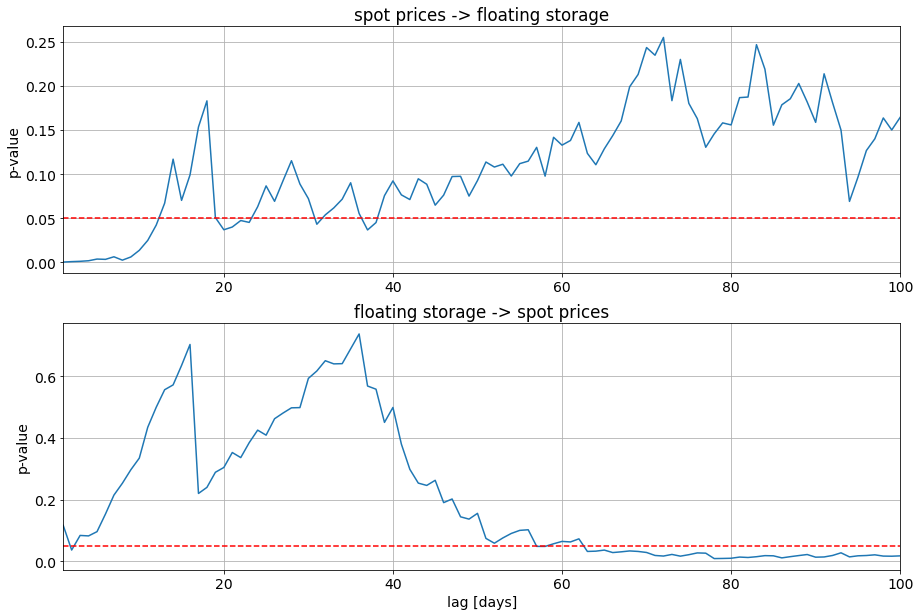

In [24]:
plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

The top plot shows significant evidence for spot prices Granger-causing floating storage in the short term (1-10 days), but no consistent evidence in the long-term. Most importantly, the bottom plot shows **significant evidence that crude oil floating storage Granger-causes spot prices with a lag of 2-3 months**. By the definition of Granger causality, this means that **floating storage may have significant predictive value for spot crude oil prices 2-3 months into the future**.

Lastly, we check whether a similar result can be found between the two price signals:

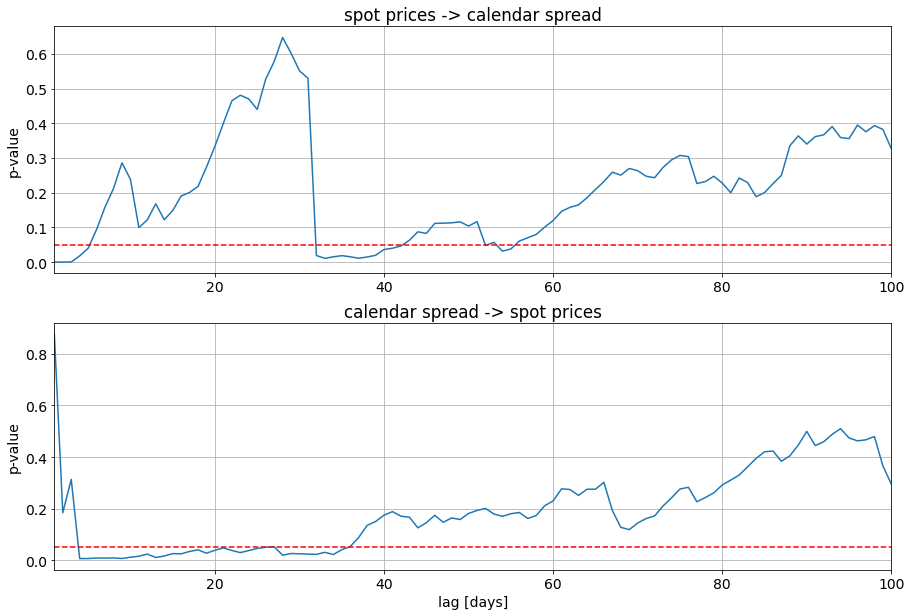

In [25]:
plot_granger_pvalues(spot_prices, calendar_spread, maxlag=MAXLAG, label_x='spot prices', label_y='calendar spread')

Though there's evidence that calendar spread Granger-causes spot prices between 4-36 days (bottom plot), there is no evidence that calendar spread has any predictive value for spot prices in the 2-3 month lag range.

## Conclusion

This Notebook presents evidence that global crude oil floating storage data has predictive value over spot WTI prices 2-3 months into the future. This evidence was obtained by applying Granger causality analysis on floating storage time series retrieved using [Vortexa's Python SDK](https://www.vortexa.com/insight/arming-commodity-experts-with-vortexas-python-sdk) and public crude oil prices downloaded from the EIA website. Granger causality test accounts for the autocorrelation that is present in both price and floating storage data, and was also able to reveal the [arbitrage-driven causal link between calendar spread and floating storage](https://www.bloomberg.com/professional/blog/floating-u-s-crude-storage-economics-and-drivers/) in the same data.

Floating storage is again starting to build up due to the contango structure in the oil market, as evidenced by the latest Vortexa data: 

2020-04-17 05:37:11,869 vortexasdk.operations — INFO — Searching Products with params: {'term': ['crude'], 'ids': [], 'product_parent': [], 'allowTopLevelProducts': True}
2020-04-17 05:37:12,012 vortexasdk.client — INFO — 18 Results to retreive. Sending 1 post requests in parallel using 6 threads.
2020-04-17 05:37:12,604 vortexasdk.operations — INFO — Searching CargoTimeSeries with params: {'filter_activity': 'storing_state', 'filter_time_min': '2020-01-08T00:00:00.000Z', 'filter_time_max': '2020-04-17T00:00:00.000Z', 'timeseries_activity_time_span_min': None, 'timeseries_activity_time_span_max': None, 'filter_charterers': [], 'filter_owners': [], 'filter_products': ['54af755a090118dcf9b0724c9a4e9f14745c26165385ffa7f1445bc768f06f11'], 'filter_vessels': [], 'filter_destinations': [], 'filter_origins': [], 'filter_storage_locations': [], 'filter_ship_to_ship_locations': [], 'filter_waypoints': [], 'disable_geographic_exclusion_rules': True, 'timeseries_frequency': 'day', 'timeseries_unit

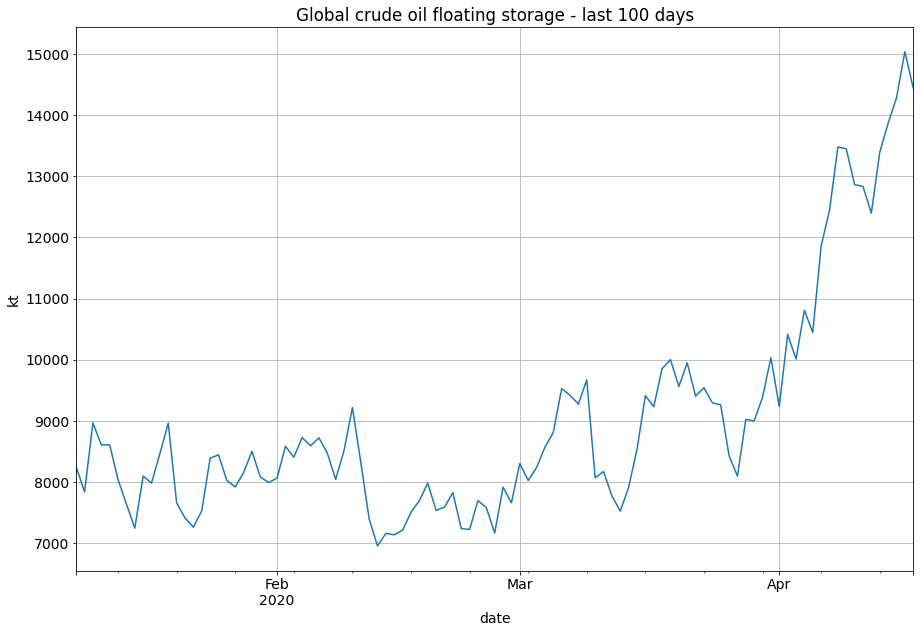

In [26]:
end_ts = pd.Timestamp('now')
start_ts = end_ts - pd.Timedelta('100 d')

df_fs_now = fetch_global_crude_floating_storage_timeseries(start_ts.date(), end_ts.date(), UNIT)

floating_storage_now = df_fs_now.set_index('date')[UNIT] / 1000
floating_storage_now.plot(title='Global crude oil floating storage - last 100 days', grid=True)
plt.xlabel('date')
plt.ylabel('k' + UNIT);

Our results highlight the importance of floating storage as a factor in the dynamics of oil markets. Traders with access to Vortexa floating storage data will have an advantage in forecasting prices 2-3 months ahead better than those without this data. With the world in turmoil and a rapidly increasing oil glut, market participants need more than ever to be kept well-informed about the state of global floating storage.